# Natural Language Procesisng: Analyzing Twitter dataset  
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ZXsQ1s8shQCjGOlpjzUY9snchPuzeMtT#scrollTo=kCE_C2OdhD1q)  
*BUS5PR1 - Sprint 02*  
by Duc Dao

# Load the datasets


In [ ]:
# Loading primary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
!pip install pyLDAvis==2.1.2
import pyLDAvis.gensim

     |████████████████████████████████| 1.6MB 7.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=12021c9849783a314af5d709f546069c0040b384e8adcbc036257abb5364f2ce
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# Load and view the dataset
df = pd.read_csv('climate_change_tweets.csv')
df.head(3)

,date,content,id,replyCount,retweetCount,likeCount,lang,url
0,2021-02-27 23:27:21+00:00,@PondSagg #ClimateChange = more #extreme #weat...,1.365810e+18,1,0,0,en,https://twitter.com/TaraVenn/status/1365805751...
1,2021-02-27 15:14:00+00:00,#ClimateChange has harshly impacted #Australia...,1.365680e+18,0,0,1,en,https://twitter.com/SteveColecchi/status/13656...
2,2021-02-27 12:28:29+00:00,#ClimateCriminal #Australia continues its mass...,1.365640e+18,1,5,6,en,https://twitter.com/AustraliaVote/status/13656...


In [ ]:
# subset df to date and content for analysis
df = pd.read_csv('climate_change_tweets.csv', usecols = ['date','content'])
df.head(1)

,date,content
0,2021-02-27 23:27:21+00:00,@PondSagg #ClimateChange = more #extreme #weat...


In [ ]:
print('total number of records in the dataset:', df.shape[0])

total number of records in the dataset: 20246


In [ ]:
df.dtypes

date       object
content    object
dtype: object

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df["date"] = df["date"].dt.date

In [ ]:
df.head(1)

,date,content
0,2021-02-27,@PondSagg #ClimateChange = more #extreme #weat...


# Preliminary analysis

**Count the number of words in each tweet**

In [ ]:
df['word_count'] = df['content'].apply(lambda x: len(str(x).split(" ")))
df.head(5)

,date,content,word_count
0,2021-02-27,@PondSagg #ClimateChange = more #extreme #weat...,48
1,2021-02-27,#ClimateChange has harshly impacted #Australia...,18
2,2021-02-27,#ClimateCriminal #Australia continues its mass...,29
3,2021-02-27,#Australia accused of 'shamefully' holding bac...,15
4,2021-02-27,#Australia accused of 'shamefully' holding bac...,15


**Count the number of characters of each tweet**

In [ ]:
df['char_count'] = df['content'].str.len()  # Includes the spaces
df.head(5)

,date,content,word_count,char_count
0,2021-02-27,@PondSagg #ClimateChange = more #extreme #weat...,48,294
1,2021-02-27,#ClimateChange has harshly impacted #Australia...,18,154
2,2021-02-27,#ClimateCriminal #Australia continues its mass...,29,254
3,2021-02-27,#Australia accused of 'shamefully' holding bac...,15,152
4,2021-02-27,#Australia accused of 'shamefully' holding bac...,15,152


**Box plot analysis for number of words and characters in each tweet**

There are some tweets contain lot of words may need to remove because according to the box plot, most of the tweets have less than 100 words

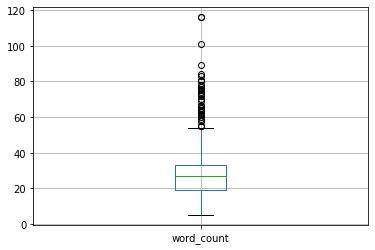

In [ ]:
df[['word_count']].boxplot()

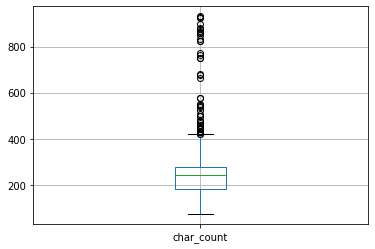

In [ ]:
df[['char_count']].boxplot()

### **Remove extreme values**  
Remove any tweet that has more than 100 words

In [ ]:
df = df[df["word_count"]< 100]

# Text pre-processing

### Transform to lowercase
Because Python is a case-sensitive language. Thus case distinction would be unnecessary

In [ ]:
df['content'] = df['content'].str.lower()
df.head()

,date,content,word_count,char_count
0,2021-02-27,@pondsagg #climatechange = more #extreme #weat...,48,294
1,2021-02-27,#climatechange has harshly impacted #australia...,18,154
2,2021-02-27,#climatecriminal #australia continues its mass...,29,254
3,2021-02-27,#australia accused of 'shamefully' holding bac...,15,152
4,2021-02-27,#australia accused of 'shamefully' holding bac...,15,152


### Remove duplicate values

In [ ]:
df = df[['date','content']]

In [ ]:
# Remove duplicate values
duplicate_count = len(df['content'])-len(df['content'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', df.shape[0])

duplicate count: 1202
total records before remove duplicates: 20243


In [ ]:
# drop duplicates (keep the last tweet of each of the duplicates)
df = df.drop_duplicates(subset='content', keep="first")
print('updated record count:', df.shape[0])

updated record count: 19041


### Cleaning the tweets
The given dataset contain a lot of mention (@somebody), hashtag (#Australia , #climatechange, #climate,. etc), retweets (RT), and urls. Those words are not relevant for this sentiment analysis, thus those words will be removed.
- Remove mentions
- Remove hashtags
- Remove retweets
- Remove urls

In [ ]:
# Import Regular Expression Python module
import re

# Define function
def remove_twitter_ids(tweet):
  # remove any sequence of characters followed by '@' sign
  mention_removed_tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(tweet))
  
  # remove multiple spaces
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_removed_tweet)) 

  return spaces_removed

df['remove_twitter'] = df['content'].apply(remove_twitter_ids)

In [ ]:
# Define the function to cleaning the Tweets
def cleanUpTweet(txt):
    # Remove mentions
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt)
    # Remove hashtags
    txt = re.sub(r'#', '', txt)
    # Remove retweets:
    txt = re.sub(r'rt : ', '', txt)
    # Remove urls
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt)
    return txt

In [ ]:
df['cleantweet'] = df['content'].apply(cleanUpTweet)
df

,date,content,remove_twitter,cleantweet
0,2021-02-27,@pondsagg #climatechange = more #extreme #weat...,climatechange more extreme weather hot amp co...,climatechange = more extreme weather! hot &am...
1,2021-02-27,#climatechange has harshly impacted #australia...,climatechange has harshly impacted australia i...,climatechange has harshly impacted australia -...
2,2021-02-27,#climatecriminal #australia continues its mass...,climatecriminal australia continues its mass p...,climatecriminal australia continues its mass p...
3,2021-02-27,#australia accused of 'shamefully' holding bac...,australia accused of shamefully holding back g...,australia accused of 'shamefully' holding back...
4,2021-02-27,#australia accused of 'shamefully' holding bac...,australia accused of shamefully holding back g...,australia accused of 'shamefully' holding back...
...,...,...,...,...
20241,2018-02-08,rt @palmboy4444: #australia: #tourism is least...,rt australia tourism is least prepared for cli...,australia: tourism is least prepared for clima...
20242,2018-01-19,#aus #eastcoast is heading for another hot sum...,aus eastcoast is heading for another hot summe...,aus eastcoast is heading for another hot summe...
20243,2018-01-16,rt @wendy_bacon: as you appreciate street #tre...,rt bacon as you appreciate street trees in aus...,"as you appreciate street trees in aus summer, ..."
20244,2018-01-15,as you appreciate street #trees in #aus #summe...,as you appreciate street trees in aus summer r...,"as you appreciate street trees in aus summer, ..."


Cleaning tweet is better in this case, use this one for the next step

In [ ]:
df['content'] = df['content'].apply(cleanUpTweet)
df = df[['date','content']]

### Remove regular expressions
A regular expression is a special sequence of characters that helps to match or find other strings or sets of strings. Does not help the machine learning process.

In [ ]:
df['content'] = df['content'].str.replace('[^\w\s]','')
df.head()

<input>:1: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \w
<ipython-input-21-31b0fa6e8891>:1: DeprecationWarning: invalid escape sequence \w
  df['content'] = df['content'].str.replace('[^\w\s]','')
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,content
0,2021-02-27,climatechange more extreme weather hot amp c...
1,2021-02-27,climatechange has harshly impacted australia ...
2,2021-02-27,climatecriminal australia continues its mass p...
3,2021-02-27,australia accused of shamefully holding back g...
4,2021-02-27,australia accused of shamefully holding back g...


### Remove digits
In this sentiment analysis numbers or digits are not relevant. Therefore, remove any digit in the Tweet

In [ ]:
# define the function
def remove_digits(sent):
  return " ".join(w for w in sent.split() if not w.isdigit())

df['content'] = df['content'].apply(remove_digits)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,date,content
0,2021-02-27,climatechange more extreme weather hot amp col...
1,2021-02-27,climatechange has harshly impacted australia i...
2,2021-02-27,climatecriminal australia continues its mass p...
3,2021-02-27,australia accused of shamefully holding back g...
4,2021-02-27,australia accused of shamefully holding back g...


### Remove Stopwords
Stopwords are irrelevant for NLP purposes because they occur frequently in the language. Therefore, they need to be removed from the dataset.  
*Use NLTK library for this task*

In [ ]:
# Load NLTK library
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# create stop words list
stop = stopwords.words('english')

# Remove not because 'not' is negative impact on sentiment analysis
stop.remove('not')

# Remove stop words (from NLTK stop word list) from the Tweets
df['content'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,content
0,2021-02-27,climatechange extreme weather hot amp cold not...
1,2021-02-27,climatechange harshly impacted australia integ...
2,2021-02-27,climatecriminal australia continues mass pollu...
3,2021-02-27,australia accused shamefully holding back glob...
4,2021-02-27,australia accused shamefully holding back glob...


### Stemming
Remove prefix, suffix etc, to derive the base form of a word

In [ ]:
# import library
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

# define the function
def stemming_function(sent):
  word_list = sent.split()
  stemmed_word_list = [stemmer.stem(word) for word in word_list]
  stemmed_sentence = " ".join(stemmed_word_list)
  return stemmed_sentence

df['content_stemmed'] = df['content'].apply(stemming_function)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,date,content,content_stemmed
0,2021-02-27,climatechange extreme weather hot amp cold not...,climatechang extrem weather hot amp cold not w...
1,2021-02-27,climatechange harshly impacted australia integ...,climatechang harshli impact australia integr e...
2,2021-02-27,climatecriminal australia continues mass pollu...,climatecrimin australia continu mass pollut pl...
3,2021-02-27,australia accused shamefully holding back glob...,australia accus shame hold back global action ...
4,2021-02-27,australia accused shamefully holding back glob...,australia accus shame hold back global action ...


### Lemmatization
Converting the given word into it's base form according to the dictionary meaning of the word.

In [ ]:
# Download wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# import library
from nltk.stem import WordNetLemmatizer
lemmtizer = WordNetLemmatizer()

# Define the function
def lemmatize_function(sent):
  word_list = sent.split()
  lemma_word_list = [lemmtizer.lemmatize(word) for word in word_list]
  lemma_sentence = " ".join(lemma_word_list)
  return lemma_sentence

df['content_lemmatized'] = df['content'].apply(lemmatize_function)
df

,date,content,content_stemmed,content_lemmatized
0,2021-02-27,climatechange extreme weather hot amp cold not...,climatechang extrem weather hot amp cold not w...,climatechange extreme weather hot amp cold not...
1,2021-02-27,climatechange harshly impacted australia integ...,climatechang harshli impact australia integr e...,climatechange harshly impacted australia integ...
2,2021-02-27,climatecriminal australia continues mass pollu...,climatecrimin australia continu mass pollut pl...,climatecriminal australia continues mass pollu...
3,2021-02-27,australia accused shamefully holding back glob...,australia accus shame hold back global action ...,australia accused shamefully holding back glob...
4,2021-02-27,australia accused shamefully holding back glob...,australia accus shame hold back global action ...,australia accused shamefully holding back glob...
...,...,...,...,...
20241,2018-02-08,australia tourism least prepared climatechange...,australia tourism least prepar climatechang be...,australia tourism least prepared climatechange...
20242,2018-01-19,aus eastcoast heading another hot summer weeke...,au eastcoast head anoth hot summer weekend wri...,au eastcoast heading another hot summer weeken...
20243,2018-01-16,appreciate street trees aus summer remember ma...,appreci street tree au summer rememb mani risk...,appreciate street tree au summer remember many...
20244,2018-01-15,appreciate street trees aus summer remember ma...,appreci street tree au summer rememb mani risk...,appreciate street tree au summer remember many...


There are a lot of wording issues in Stemming, ex: rememb, mani, climachang,.. Thought observation, Lemmatization algorithm seems to be working better in this case when compared to the Stemmming algorith.  
**Therefore, we will user Lemmatized data for further analysis**

In [ ]:
df['content'] = df['content'].apply(lemmatize_function)

### Word frequency analysis

In [ ]:
word_frequency = pd.Series(' '.join(df['content']).split()).value_counts()

In [ ]:
# Top common words
word_frequency[:10]  # get top 10

australia        21385
climatechange    19029
climate           4072
auspol            2798
amp               2552
change            2300
fire              2215
climatecrisis     2076
bushfires         1942
environment       1663
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


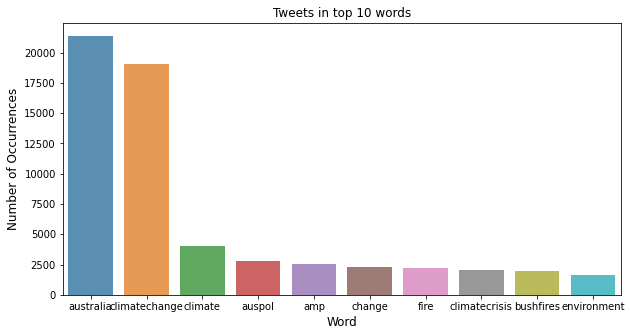

In [ ]:
# import library
import matplotlib.pyplot as plt

# Visualize the top word counts 
word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(word_count.index, word_count.values, alpha=0.8)
plt.title('Tweets in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

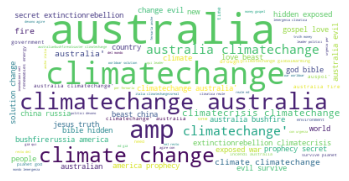

In [ ]:
# import library
from PIL import Image
from wordcloud import WordCloud

# create word cloud
corpus = list(df['content'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# take a look at the least common words
word_frequency[-10:]  # get top 10

lansing                      1
lowemissions                 1
heatwavecode                 1
numerose                     1
innovativetools              1
includendo                   1
globalclimateemergency       1
eastgippslandfires           1
connectionscollaborations    1
aghast                       1
dtype: int64

From the word cloud we could identify that the terms **australia, climatechange, climate, change** has been mentioned frequently. But this is expected - it will not generate much an insight.  
**Therefore, those high frequency non-insightful words will be removed.**

### Remove common words  
Based on the context, those expected and non-insightful words will be removed from the dataset

In [ ]:
# Creating a list of custom stopwords
new_words_to_remove = ["australia", "climatechange", "climate", "change"]

In [ ]:
# Remove common words using lambda function
df['content'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_to_remove))
df.head(5)

,date,content,content_stemmed,content_lemmatized
0,2021-02-27,extreme weather hot amp cold not want roast be...,climatechang extrem weather hot amp cold not w...,climatechange extreme weather hot amp cold not...
1,2021-02-27,harshly impacted integral ecology core committ...,climatechang harshli impact australia integr e...,climatechange harshly impacted australia integ...
2,2021-02-27,climatecriminal continues mass pollution plane...,climatecrimin australia continu mass pollut pl...,climatecriminal australia continues mass pollu...
3,2021-02-27,accused shamefully holding back global action ...,australia accus shame hold back global action ...,australia accused shamefully holding back glob...
4,2021-02-27,accused shamefully holding back global action ...,australia accus shame hold back global action ...,australia accused shamefully holding back glob...


**Re-attempt to compose a frequency appearing word list.**

In [ ]:
# Create a word frequency series. (This is a pandas series)
word_frequency = pd.Series(' '.join(df['content']).split()).value_counts()

In [ ]:
# Look at the top 10 words
word_frequency[:10]

auspol              2798
amp                 2552
fire                2215
climatecrisis       2076
bushfires           1942
environment         1663
coal                1644
climateemergency    1615
globalwarming       1488
energy              1481
dtype: int64

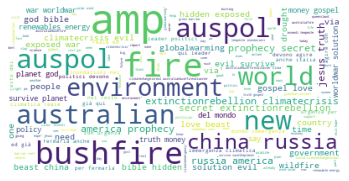

In [ ]:
# Generate word cloud
corpus = list(df['content'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Bigrams and Trigrams
An **n-gram** is a contiguous sequence of n items from a given sample of text or speech. They are basically a set of co-occuring words within a given window. When computing the n-grams, the shift is one-step forward (although you can move X words forward in more advanced scenarios)

In [ ]:
# import library for N-grams
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Define function to generate most frequently occuring Bi-grams
def get_ngrams(corpus, ngram_range=(2, 2)):
    
    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create BoW feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0) 

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

## **Bigrams**

In [ ]:
bigrams_content = get_ngrams(df['content'].tolist(), ngram_range=(2, 2))

# Convert bigrams of both datasets to a dataframe with column names bi-gram and frequency.
bigrams_content_df = pd.DataFrame(bigrams_content)
bigrams_content_df.columns=["Bi-gram", "Freq"]


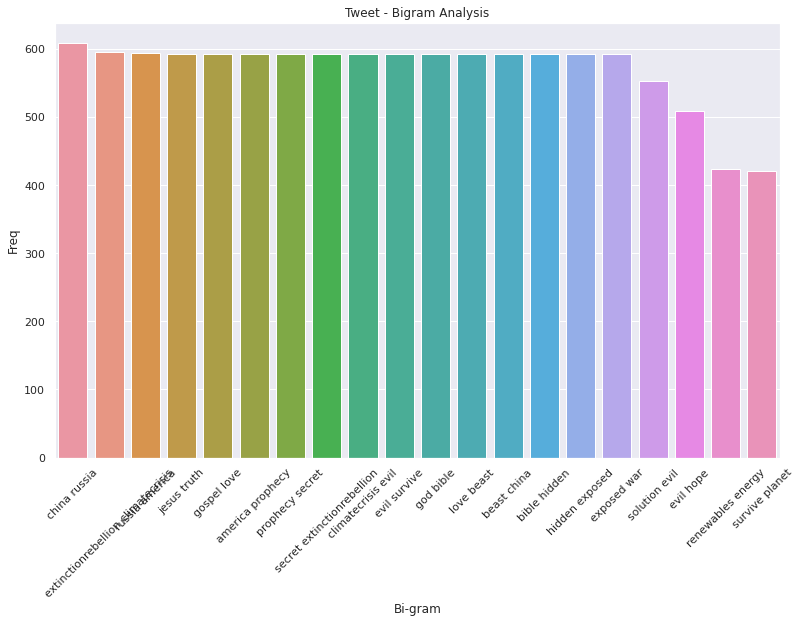

In [ ]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigrams_content_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=45)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Tweet - Bigram Analysis')
plt.show()

Observe that in Climate change Tweet dataset, there are many words related to **location** such as Melbourne, Sydnet, China, Russia, America. Bigram frequencies can be used to differentiate and compare topics of interest.

## **Trigrams**

In [ ]:
trigrams_content = get_ngrams(df['content'].tolist(), ngram_range=(3, 3))

# Convert trigrams of both datasets to a dataframe with column names tri-gram and frequency.
trigrams_content_df = pd.DataFrame(trigrams_content)
trigrams_content_df.columns=["Tri-gram", "Freq"]

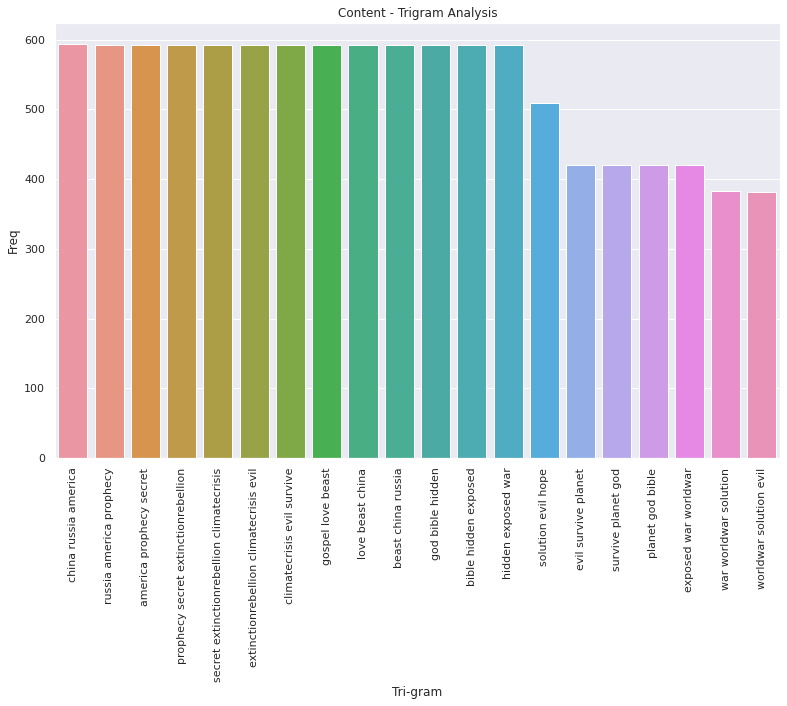

In [ ]:
# Barplot of most freq Tri-grams
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_content_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Content - Trigram Analysis')
plt.show()

Similarly, in trigrams, there are many words related to location as well.  
In other words, countries are the keyword that appeared most in the discussion about climate change; especially China, Russia, America

# Sentiment Analysis  

Using Sentiment analysis to determining the attitude or the emotion of the writer, i.e., whether it is positive or negative or neutral.  

*Using Textblob library. The sentiment function of textblob returns the polarity of the sentence, i.e., a float value which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement and 0 mean neutral.*

## Overall sentiment score

Calculate the percentage of positive comments from all the tweets


In [ ]:
# import library
from textblob import TextBlob

Derive sentiment of each sentence.

In [ ]:
# Extract sentiments from the tweets
df['sentiment'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
# View first 20 tweets with respective sentiment value
print(df[['content', 'sentiment']][:20])

                                              content  sentiment
0   extreme weather hot amp cold not want roast be...   0.075000
1   harshly impacted integral ecology core committ...  -0.200000
2   climatecriminal continues mass pollution plane...   0.000000
3   accused shamefully holding back global action ...   0.033333
4   accused shamefully holding back global action ...   0.033333
5   climatefriday reading ocean current power word...   0.142857
6   accused shamefully holding back global action ...   0.033333
7   sadly apparent lacking country effort address ...   0.093182
8   post 15c average increase temperature since ap...  -0.075000
9   flying foxeslg bat refugee key forest ecosyste...  -0.062500
10  post 2c average increase temperature since app...  -0.075000
11  firstplace managing auspol let go gold climate...   0.000000
12  australian gdp viewed global soft power rise b...   0.325000
13  making difference role comparative biology tac...   0.100000
14  good morning news tod

**Categorize of Tweets**  as Negative, Neutral and Positive.

In [ ]:
# define function negative, nautral, positive analysis
def getTextAnalysis(a):
    if a < 0:
        return "Negative"
    elif a == 0:
        return "Neutral"
    else:
        return "Positive"

In [ ]:
# apply function and create another feature called Score and display the first 20 values.
df['Score'] = df['sentiment'].apply(getTextAnalysis)
df[['content', 'sentiment', 'Score']].head(20)

,content,sentiment,Score
0,extreme weather hot amp cold not want roast be...,0.075000,Positive
1,harshly impacted integral ecology core committ...,-0.200000,Negative
2,climatecriminal continues mass pollution plane...,0.000000,Neutral
3,accused shamefully holding back global action ...,0.033333,Positive
4,accused shamefully holding back global action ...,0.033333,Positive
5,climatefriday reading ocean current power word...,0.142857,Positive
6,accused shamefully holding back global action ...,0.033333,Positive
7,sadly apparent lacking country effort address ...,0.093182,Positive
8,post 15c average increase temperature since ap...,-0.075000,Negative
9,flying foxeslg bat refugee key forest ecosyste...,-0.062500,Negative


Calculate the percentage of positive tweets from all the tweets


In [ ]:
positive = df[df['Score'] == 'Positive']

print(str(positive.shape[0]/(df.shape[0])*100) + " % of positive tweets")

34.630534110603435 % of positive tweets


In [ ]:
negative = df[df['Score'] == 'Negative']
print(str(negative.shape[0]/(df.shape[0])*100) + " % of negative tweets")

26.31164329604538 % of negative tweets


In [ ]:
neutral = df[df['Score'] == 'Neutral']
print(str(neutral.shape[0]/(df.shape[0])*100) + " % of neutral tweets")

39.05782259335119 % of neutral tweets


Visualise positive, negative, neutral tweets using Matplotlib.

In [ ]:
import matplotlib.pyplot as plt

<BarContainer object of 3 artists>

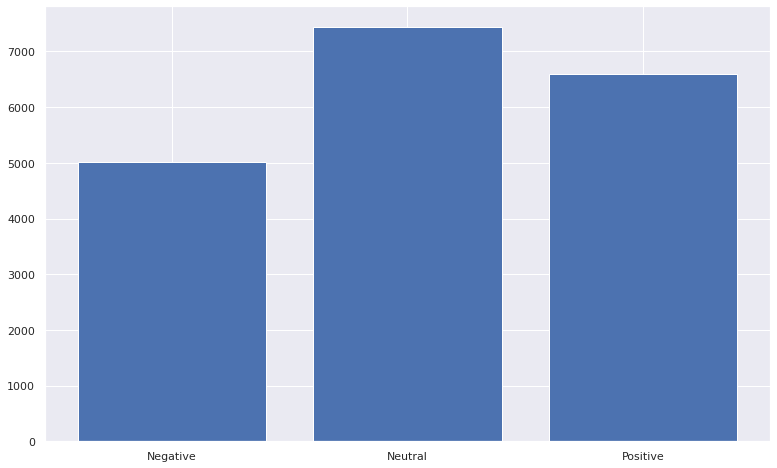

In [ ]:
labels = df.groupby('Score').count().index.values

values = df.groupby('Score').size().values

plt.bar(labels, values)

We can see how Negative, Neutral and Positive tweets about climate change since early 2018

## Sentiment over time  
Analyse sentiments for each comment, aggregate into the sentiment of particular day and derive a sentiment timeline.


Plot sentiment over time.

In [ ]:
# Plot comment sentiment timeline
# df_senti_reddit_date_wise = df_reddit.groupby(['date'])['sentiment'].mean().reset_index(name='mean_sentiment_comment').set_index('date')
# ax = df_senti_reddit_date_wise.plot()

In [ ]:
df.head(1)

,date,content,content_stemmed,content_lemmatized,sentiment,Score
0,2021-02-27,extreme weather hot amp cold not want roast be...,climatechang extrem weather hot amp cold not w...,climatechange extreme weather hot amp cold not...,0.075,Positive


In [ ]:
df_avg_senti = df.groupby(['date'])['sentiment'].mean().reset_index(name='mean_sentiment')
df_avg_senti.head(1)

,date,mean_sentiment
0,2018-01-01,0.166667


In [ ]:
# Plot comment sentiment timeline
import plotly.express as px

fig = px.line(df_avg_senti, x="date", y="mean_sentiment", title='Sentiment over time on Twitter')
fig.show()

/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.s

# Topic modeling

In [ ]:
# create new df for modeling
df_processed = df

In [ ]:
# import libraries
import tempfile
import logging

In [ ]:
# Setting up the environment for LDA algorithm.
temp_df = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(temp_df))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


Folder "/tmp" will be used to save temporary dictionary and corpus.


In [ ]:
# Convert the tweets as the text corpus.
corpus = list(df_processed['content'])

In [ ]:
# view first 5 copus
corpus[:5]

['extreme weather hot amp cold not want roast beautiful nativeanimals blown map bigger cyclone ignorant celebrate niagra fall freezing sign myth',
 'harshly impacted integral ecology core committment tackle',
 'climatecriminal continues mass pollution planet backlash coming wait international boycott holding olympicgames auspol extinctionrebellion',
 'accused shamefully holding back global action climatestrike climatecrisis',
 'accused shamefully holding back global action climatestrike climatecrisis']

In [ ]:
# Tokenization
df_texts = [[word for word in str(document).split()] for document in corpus]

In [ ]:
# display first 5 values
df_texts[:5]

[['extreme',
  'weather',
  'hot',
  'amp',
  'cold',
  'not',
  'want',
  'roast',
  'beautiful',
  'nativeanimals',
  'blown',
  'map',
  'bigger',
  'cyclone',
  'ignorant',
  'celebrate',
  'niagra',
  'fall',
  'freezing',
  'sign',
  'myth'],
 ['harshly',
  'impacted',
  'integral',
  'ecology',
  'core',
  'committment',
  'tackle'],
 ['climatecriminal',
  'continues',
  'mass',
  'pollution',
  'planet',
  'backlash',
  'coming',
  'wait',
  'international',
  'boycott',
  'holding',
  'olympicgames',
  'auspol',
  'extinctionrebellion'],
 ['accused',
  'shamefully',
  'holding',
  'back',
  'global',
  'action',
  'climatestrike',
  'climatecrisis'],
 ['accused',
  'shamefully',
  'holding',
  'back',
  'global',
  'action',
  'climatestrike',
  'climatecrisis']]

In [ ]:
# import libraries
from gensim import corpora, models, similarities
import os

In [ ]:
# Create a dictionary based on the tokanized words of all the tweets.
dictionary = corpora.Dictionary(df_texts)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(temp_df, 'df.dict'))

2021-05-25 09:01:07,550 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-05-25 09:01:07,804 : INFO : adding document #10000 to Dictionary(20454 unique tokens: ['amp', 'beautiful', 'bigger', 'blown', 'celebrate']...)
2021-05-25 09:01:08,013 : INFO : built Dictionary(30409 unique tokens: ['amp', 'beautiful', 'bigger', 'blown', 'celebrate']...) from 19041 documents (total 303105 corpus positions)
2021-05-25 09:01:08,014 : INFO : saving Dictionary object under /tmp/df.dict, separately None
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

2021-05-25 09:01:08,029 : INFO : saved /tmp/df.dict


In [ ]:
# Print the dictionary
print(dictionary.token2id)

{'amp': 0, 'beautiful': 1, 'bigger': 2, 'blown': 3, 'celebrate': 4, 'cold': 5, 'cyclone': 6, 'extreme': 7, 'fall': 8, 'freezing': 9, 'hot': 10, 'ignorant': 11, 'map': 12, 'myth': 13, 'nativeanimals': 14, 'niagra': 15, 'not': 16, 'roast': 17, 'sign': 18, 'want': 19, 'weather': 20, 'committment': 21, 'core': 22, 'ecology': 23, 'harshly': 24, 'impacted': 25, 'integral': 26, 'tackle': 27, 'auspol': 28, 'backlash': 29, 'boycott': 30, 'climatecriminal': 31, 'coming': 32, 'continues': 33, 'extinctionrebellion': 34, 'holding': 35, 'international': 36, 'mass': 37, 'olympicgames': 38, 'planet': 39, 'pollution': 40, 'wait': 41, 'accused': 42, 'action': 43, 'back': 44, 'climatecrisis': 45, 'climatestrike': 46, 'global': 47, 'shamefully': 48, 'climatefriday': 49, 'current': 50, 'day': 51, 'diary': 52, 'ecosystem': 53, 'extremetemperature': 54, 'extremeweather': 55, 'ocean': 56, 'omen': 57, 'power': 58, 'pressure': 59, 'reading': 60, 'right': 61, 'word': 62, 'scottmorrison': 63, 'address': 64, 'appa

In [ ]:
# Convert the text dictionary to bag of words model
corpus = [dictionary.doc2bow(text) for text in df_texts]

In [ ]:
# convert tweet to tokens and present it as id from the dictionary
tweet_id = 0
print(df_texts[tweet_id]) # each tweet converted to tokens
print(dictionary.doc2bow(df_texts[tweet_id])) # each token is represented as a id from a dictionary

['extreme', 'weather', 'hot', 'amp', 'cold', 'not', 'want', 'roast', 'beautiful', 'nativeanimals', 'blown', 'map', 'bigger', 'cyclone', 'ignorant', 'celebrate', 'niagra', 'fall', 'freezing', 'sign', 'myth']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]


## Generate the topic model

In [ ]:
# Construct TF-IDF features from the dictionary.
tfidf = models.TfidfModel(corpus)

2021-05-25 09:01:08,493 : INFO : collecting document frequencies
2021-05-25 09:01:08,495 : INFO : PROGRESS: processing document #0
2021-05-25 09:01:08,538 : INFO : PROGRESS: processing document #10000
2021-05-25 09:01:08,574 : INFO : calculating IDF weights for 19041 documents and 30408 features (291867 matrix non-zeros)


In [ ]:
# Transform the tweets as TF-IDF feature vectors
corpus_tfidf = tfidf[corpus]

In [ ]:
#Define 40 topics capture through LDA.
total_topics = 40

In [ ]:
#Build the LDA topic model.
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf]

2021-05-25 09:01:08,690 : INFO : using symmetric alpha at 0.025
2021-05-25 09:01:08,693 : INFO : using symmetric eta at 0.025
2021-05-25 09:01:08,704 : INFO : using serial LDA version on this node
2021-05-25 09:01:08,902 : INFO : running online (single-pass) LDA training, 40 topics, 1 passes over the supplied corpus of 19041 documents, updating model once every 2000 documents, evaluating perplexity every 19041 documents, iterating 50x with a convergence threshold of 0.001000
2021-05-25 09:01:08,904 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-05-25 09:01:08,908 : INFO : PROGRESS: pass 0, at document #2000/19041
2021-05-25 09:01:10,294 : INFO : merging changes from 2000 documents into a model of 19041 documents
2021-05-25 09:01:10,453 : INFO : topic #25 (0.025): 0.016*"koala" + 0.012*"new" + 0.012*"amp" + 0.010*"extinction" + 0.007*"globalwarming" + 0.007*"wildlife" + 0.006*"news" + 0.006*"extin

In [ ]:
# Print the Keyword in the 10 topics
lda.show_topics(total_topics, num_words=6)

[(0,
  '0.109*"au" + 0.016*"heat" + 0.016*"show" + 0.016*"auspol" + 0.015*"wave" + 0.015*"australian"'),
 (1,
  '0.063*"cleanenergy" + 0.054*"renewableenergy" + 0.022*"melbourne" + 0.019*"technology" + 0.016*"latest" + 0.015*"ghgt14"'),
 (2,
  '0.043*"action" + 0.021*"student" + 0.018*"threat" + 0.017*"government" + 0.017*"need" + 0.016*"take"'),
 (3,
  '0.065*"tesla" + 0.027*"australiafires" + 0.021*"globalwarming" + 0.018*"hundred" + 0.015*"waste" + 0.015*"made"'),
 (4,
  '0.045*"evil" + 0.036*"europe" + 0.026*"money" + 0.025*"africa" + 0.024*"america" + 0.023*"hidden"'),
 (5,
  '0.037*"amp" + 0.028*"rising" + 0.027*"farmer" + 0.019*"water" + 0.018*"result" + 0.015*"nocoal"'),
 (6,
  '0.025*"coal" + 0.020*"amp" + 0.019*"market" + 0.017*"tourism" + 0.014*"auspol" + 0.012*"health"'),
 (7,
  '0.079*"energy" + 0.061*"renewables" + 0.057*"coal" + 0.052*"solar" + 0.046*"auspol" + 0.031*"stopadani"'),
 (8,
  '0.054*"melbourne" + 0.045*"sydney" + 0.043*"globalwarming" + 0.041*"brisbane" + 0.

From the keywords of the topics above we can see the importance of a keyword to the topic.  

**For example**: for the first topic: '0.065*"usa" + 0.035*"greenhousegas" + 0.035*"day" + 0.026*"india" + 0.024*"canada" + 0.022*"ghgt14"'). We can see the importance of the countries (usa, india, canada) and greenhouse gas and day in this topic. The weight of usa in this topic os 0.065. This topic could be the comparison of greenhouse gas emission between three countries over time.  

**The discussion in Australia on global warming and sustainability** has result: '0.093*"melbourne" + 0.084*"sydney" + 0.076*"sustainability" + 0.058*"brisbane" + 0.052*"canberra" + 0.050*"globalwarming"'). In which, state (location) names' weight are 0.093, 0.084, 0.058 and 0.052 for melbourne, sydney, brisbane and canberra.


# Interactive topic analyzer


In [ ]:
!pip install pyLDAvis==2.1.2
import pyLDAvis.gensim

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
36     -80.239197   40.540958       1        1  6.098401
24      80.307434   12.615297       2        1  6.065318
14      17.365572  -92.934853       3        1  5.079134
3      -91.586395   84.280121       4        1  4.795235
37     -31.500439   -6.426438       5        1  4.771219
11      17.941580   92.836113       6        1  4.116942
29      65.467339  -26.012037       7        1  3.072127
12     -47.879021   20.812229       8        1  2.950430
10       9.714099   20.584171       9        1  2.921741
30     -20.108948   34.851429      10        1  2.852157
19     -52.292774  -36.141571      11        1  2.774567
8       54.579895  119.539894      12        1  2.755593
32      38.651253   20.095949      13        1  2.696745
15    -112.623070   43.773220      14        1  2.625309
27     -27.916582  109.846283      15        1  2.607670
31     -10.520375   69.350609      16        1  2.597072
25     -70.088905  -88.648918      17        1  2.462719
21     -56.631805   87.877617      18        1  2.448446
34       5.085562  -63.920860      19        1  2.422493
2      -68.212730   -7.063884      20        1  2.405671
9       96.350349   52.318211      21        1  2.404594
0     -105.516869   -6.360021      22        1  2.214368
17      -0.677660   -7.114133      23        1  2.111607
1      -55.803341 -123.333969      24        1  2.055748
18     117.658173  -23.382019      25        1  1.712274
7     -113.496643  -79.407028      26        1  1.545335
5      -18.756790  -41.556660      27        1  1.412145
28      16.253485  -34.159576      28        1  1.408534
16      45.513126  -57.113380      29        1  1.388006
6      -42.312923  -67.051903      30        1  1.385075
23     -46.433102   60.541386      31        1  1.384710
13     -83.900414  -45.805622      32        1  1.384389
39      33.912930  -10.544646      33        1  1.384278
20      53.806732   56.485012      34        1  1.384278
22      19.261103   54.740528      35        1  1.384278
26     109.671608  -98.191353      36        1  1.384278
4       44.639164 -130.184219      37        1  1.384278
33     -22.737900  -99.739395      38        1  1.384278
35      79.279945  -80.401810      39        1  1.384278
38      12.801771  126.928673      40        1  1.384278, topic_info=            Term       Freq      Total Category  logprob  loglift
4874       tesla  48.000000  48.000000  Default  30.0000  30.0000
310      pacific  40.000000  40.000000  Default  29.0000  29.0000
129           au  38.000000  38.000000  Default  28.0000  28.0000
1714      sydney  51.000000  51.000000  Default  27.0000  27.0000
223        china  35.000000  35.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
75           new   9.972711  36.586909  Topic40  -3.0572   2.9802
1500       agree   2.145227   4.266940  Topic40  -4.5938   3.5923
1499    agchatoz   1.594206   2.901548  Topic40  -4.8906   3.6811
424   endangered   1.277320   1.956441  Topic40  -5.1123   3.8536
1385        hope   3.581986  15.739155  Topic40  -4.0811   2.7998

[2200 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
1625      10  0.875573         40c
18292      1  1.034740         5th
4973      23  1.603187     abandon
4577      30  1.191692      abbott
5324       8  0.675270      abc730
...      ...       ...         ...
2928       7  0.852476  zerocarbon
2440       6  0.923668   zerowaste
261        5  0.909059        zone
3080      34  1.601585           à
2395      36  1.027343           è

[3388 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[37, 25, 15, 4, 38, 12, 30, 13, 11, 31, 20, 9, 33, 16, 28, 32, 26, 22, 35, 3, 10, 1, 18, 2, 19, 8, 6, 29, 17, 7, 24, 14, 40, 21, 23, 27, 5, 34, 36, 39])

The Salient Terms list above represents the weight by the term's overall frequency. In which, we can see that most of the Tweet are about climate change in au, the changes of weather, and that changes are somehow extremely rediculous  

We can select the topic to get the common terms of the topic.  

**For example**, the first topic (selected topic is 1), in this topic, the topic 5 terms are protest, hope, extinctionrebellion, hot and westernaustralia.